Import libaries

In [77]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as sgnl
from scipy.optimize import minimize
from mbrtc import *


In [78]:
# Adjust the encoder signal array such that it is in the following (numpy array) form:
y = np.array([89, 89, 92, 91, 90, 91, 90, 88, 84, 82, 80, 76, 71, 67, 63, 57, 53, 48, 42, 34, 28, 22, 16, 8, 3, -4, -12, -16, -23, -31, -35, -44, -48, -52, -59, -62, -68, -70, -75, -80, -80, -83, -86, -88, -87, -88, -90, -88, -88, -87, -86, -83, -80, -78, -75, -71, -67, -63, -59, -53, -50, -45, -38, -31, -24, -18, -14, -7, -1, 3, 10, 17, 19, 26, 34, 36, 37, 23, 16, 13, 2, -4, -9, -21, -26, -32, -44, -45, -53, -63, -65, -72, -77, -84, -86, -89, -97, -98, -100, -102, -106, -105, -106, -106, -106, -105, -102, -101, -98, -94, -89, -86, -82, -77, -72, -66, -60, -53, -45, -39, -32, -24, -18, -11, -3, 3, 10, 19, 24, 31, 39, 44, 50, 56, 62, 65, 69, 75, 78, 81, 85, 88, 89, 89, 92, 92, 92, 90, 90, 89, 86, 83, 81, 77, 72, 68, 65, 60, 54, 48, 44, 36, 30, 25, 17, 11, 5, -3, -8, -14, -22, -27, -34, -41, -46, -54, -51, -38, -34, -30, -20, -13, -9, 1, 7, 12, 23, 26, 32, 40, 42, 50, 53, 57, 63, 65, 71, 71, 76, 77])
# Do the same for the control signal:
u = np.array([-200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0])

# Run the following System identification code to get the model of the system:

N = len(u)           # number of samples
h = 0.01             # sampling time 
td = h*np.arange(N)  # discrete time instants

def param2ss(x,h):
    # helper function to get the state-space matrices out of the
    # optimization vector x (h is the sampling time)
    a,b,c,d,e=x # model and initial state parameters to optimize
    A = np.array([[0.,1.],[a*(-53), b*(-0.118)]])
    B = np.array([[0.],[c*(-3.0)]])
    C = np.array([[0.,1.]])
    D = np.array([[0.]])
    Ad,Bd,Cd,Dd = c2d_zoh(A,B,C,D,h)
    x0 = np.array([d,e])
    return Ad,Bd,Cd,Dd,x0

def func(x,u,y,h):
    # helper function for the optimization, given the
    # parameter vector x, the input-signal u, output-signal y
    # and the sampling time h, the error between the measured output
    # and the model-based simulated output is to be minimized
    Ad,Bd,Cd,Dd,x0 = param2ss(x,h)
    ye = sim(Ad,Bd,Cd,Dd,u,x0)  # simulated output
    return np.linalg.norm(y-ye) # cost-value to be minimized

# System identification step:
# Estimate the discrete-time state-space matrices and the initial-state
# that fit best with the recorded input/output data
# The function func defined above is to be minimized by function minimize from scipy.optimize:
x_init = np.array([1.,1.,1.,1.,y[0]])
other_func_args = (u,y,h)
result = minimize(func,x_init,other_func_args)
Ad,Bd,Cd,Dd,x0 = param2ss(result['x'],h)
print(Ad,Bd,Cd,Dd)
# simulate the output of the model
ye = sim(Ad,Bd,Cd,Dd,u,x0)


[[ 0.99734506  0.00998525]
 [-0.53064888  0.99616564]] [[-0.00015024]
 [-0.03002946]] [[0. 1.]] [[0.]]


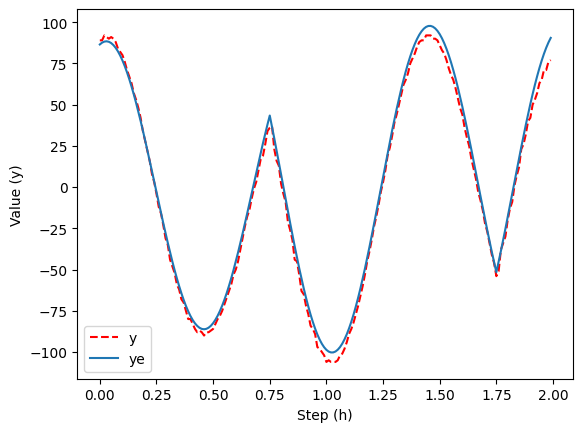

In [79]:
# Step 6) plot the measured y and the simulated ye and check whether they are close to eachother or not
plt.plot(td,y,"r--",td,ye)
plt.xlabel('Step (h)')
plt.ylabel('Value (y)')
plt.legend(["y","ye"])
plt.show()

In [80]:
# Step 7) Calculate the state-feedback gain L such that the closed-loop poles are both in 0.8, use the function place(!)
L = place(Ad,Bd,[0.8, 0.8])
print(L)



[[-115.4726003   -12.52642373]]


In [81]:
# Step 8) Calculate the observer gain K such that the observer-error poles are both in 0.8, use the function place(!)
K = place(np.transpose(Ad),np.transpose(Cd),[0.8, 0.8])
print(K)
K = K.T

[[-0.06340617  0.3935107 ]]


In [82]:
# Step 9) Calculate the state-space controller matrices by:

print("Ad:",Ad)
print("K:",K)
print("Cd:",Cd)
print("Bd:",Bd)
print("L:",L)

Actrl = Ad-K@Cd-Bd@L
Bctrl = K
Cctrl = -L
Dctrl = np.zeros((1,1))

print("Actrl:",Actrl)



# Step 10) Create the closed-loop system of edukit pendulum with controller by:
# Note the positive feedback, because the negative value is already in Cctrl(!)
Afb,Bfb,Cfb,Dfb = ss_feedback(Ad,Bd,Cd,Dd,Actrl,Bctrl,Cctrl,Dctrl,np.array([+1]))

Ad: [[ 0.99734506  0.00998525]
 [-0.53064888  0.99616564]]
K: [[-0.06340617]
 [ 0.3935107 ]]
Cd: [[0. 1.]]
Bd: [[-0.00015024]
 [-0.03002946]]
L: [[-115.4726003   -12.52642373]]
Actrl: [[ 0.97999606  0.0715094 ]
 [-3.9982284   0.22649324]]


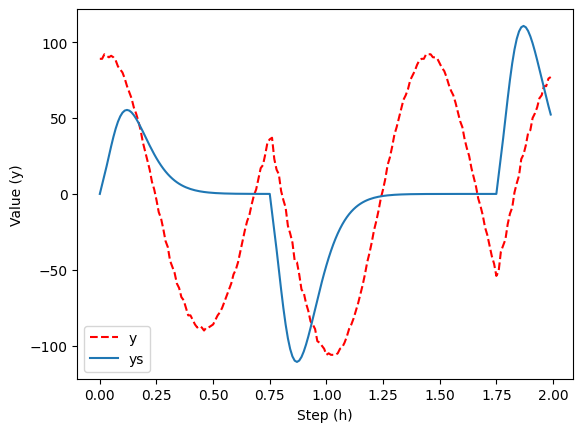

In [83]:
# Step 11) Simulate the closed-loop system with the original control signal u as input
ys = sim(Afb,Bfb,Cfb,Dfb,u)

plt.plot(td,y,"r--",td,ys)
plt.xlabel('Step (h)')
plt.ylabel('Value (y)')
plt.legend(["y","ys"])
plt.show()

#          Does the controller work?
#yec_uc = sim(Afb,Bfb,Cfb,Dfb,u)
#yec = yec_uc#[0,:]
#uc = yec_uc[1,:]
